In [67]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from scripts import MONGO_URL
from scripts.analysis import data, plot

plot.init_matplotlib()
W, H = 5.5, 2.5


def pad_missing_months(ts: pd.Series) -> pd.Series:
    start, end = ts.index[0], ts.index[-1]
    all_months = map(
        lambda month: month.strftime("%Y-%m"),
        pd.date_range(start=start, end=end, freq="MS"),
    )
    return ts.reindex(all_months, fill_value=0)


def aggreagte_user_ts(fake_type: str, repo_months: set[tuple[str, str]]) -> pd.Series:
    assert fake_type in ["low_activity", "clustered"]
    client = pymongo.MongoClient(MONGO_URL)
    ts_users = pd.DataFrame(
        map(
            lambda x: {
                "repo": x["repo"],
                "month": x["starred_at"][:7],
                "actor": x["actor"],
            },
            filter(
                lambda x: (x["repo"], x["starred_at"][:7]) in repo_months,
                list(
                    client.fake_stars[f"{fake_type}_stars"].find(
                        {
                            "repo": {"$in": [x[0] for x in repo_months]},
                            fake_type: True,
                        }
                    )
                ),
            ),
        ),
    ).groupby("month").agg({"actor": set})
    ts_users.rename(columns={"actor": f"{fake_type}_actors"}, inplace=True)
    client.close()
    return pad_missing_months(ts_users)

In [47]:
repo_with_campaign = data.get_repos_with_campaign()
stars_by_month = data.get_fake_stars_by_month()
stars_by_month = stars_by_month[stars_by_month.month != "2024-10"]

In [58]:
ts_real = pd.read_csv("data/all_github_stars_by_month.csv").set_index("month")[
    "n_stars"
]
ts_fake = stars_by_month.groupby("month").sum()[
    ["n_stars_low_activity", "n_stars_clustered"]
]
ts_repos = pad_missing_months(
    stars_by_month[stars_by_month.anomaly].groupby("month").count()[["repo"]]
)

In [94]:
ts_users = (
    pd.read_csv("data/all_github_users_by_month.csv")
    .set_index("month")["n_active_users"]
    .sort_index()
)
repo_months = set(
    stars_by_month[stars_by_month.anomaly][["repo", "month"]].apply(tuple, axis=1)
)
ts_users_low_activity = aggreagte_user_ts("low_activity", repo_months)
ts_users_clustered = aggreagte_user_ts("clustered", repo_months)

ts_fake_users = pd.concat([ts_users_low_activity, ts_users_clustered], axis=1)
ts_fake_users.low_activity_actors = ts_fake_users.low_activity_actors.apply(
    lambda x: x if not pd.isna(x) and not x == 0 else set()
)
ts_fake_users.clustered_actors = ts_fake_users.clustered_actors.apply(
    lambda x: x if not pd.isna(x) and not x == 0 else set()
)
ts_fake_users["all"] = ts_fake_users.apply(
    lambda x: len(x["low_activity_actors"] | x["clustered_actors"]), axis=1
)
ts_fake_users["both"] = ts_fake_users.apply(
    lambda x: len(x["low_activity_actors"] & x["clustered_actors"]), axis=1
)
ts_fake_users["low_activity_actors"] = ts_fake_users["low_activity_actors"].apply(len)
ts_fake_users["clustered_actors"] = ts_fake_users["clustered_actors"].apply(len)
ts_fake_users["low_activity_only"] = (
    ts_fake_users["low_activity_actors"] - ts_fake_users["both"]
)
ts_fake_users["clustered_only"] = (
    ts_fake_users["clustered_actors"] - ts_fake_users["both"]
)

month
2024-05    0.047792
2024-06    0.112543
2024-07    0.102646
2024-08    0.082854
2024-09    0.051155
dtype: float64
month
2024-05    293053.0
2024-06    715243.0
2024-07    729723.0
2024-08    511644.0
2024-09    299210.0
dtype: float64


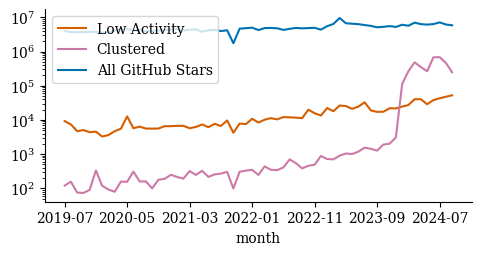

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(W, H))
ts_fake.plot(kind="line", ax=ax, color=["C2", "C3"])
ts_real.plot(kind="line", ax=ax, color="C0")
ax.set_yscale("log")
ax.legend(loc="upper left", labels=["Low Activity", "Clustered", "All GitHub Stars"])
plot.remove_spines(ax)
fig.savefig("plots/ts_stars.pdf", bbox_inches="tight")

percentage = (
    ts_fake.n_stars_low_activity + ts_fake.n_stars_clustered
) / ts_real
print(percentage.tail())
print((ts_fake.n_stars_low_activity + ts_fake.n_stars_clustered).tail())

month
2024-05    0.090386
2024-06    0.158271
2024-07    0.153121
2024-08    0.098314
2024-09    0.085623
Name: repo, dtype: float64
         repo
month        
2024-05  1303
2024-06  2504
2024-07  3216
2024-08  1429
2024-09  1178


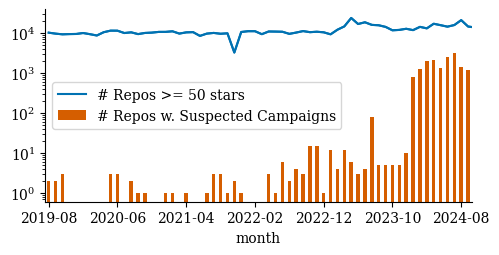

In [43]:
all_spiky_repos = pd.read_csv("data/all_github_repos_with_spikes.csv")
all_spiky_repos = all_spiky_repos.groupby("month").count()

fig, ax = plt.subplots(1, 1, figsize=(W, H))
ts_repos.plot(kind="bar", ax=ax, color="C2")
all_spiky_repos.plot(kind="line", ax=ax, color="C0")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=["# Repos >= 50 stars", "# Repos w. Suspected Campaigns"])
ax.set_yscale("log")
ax.set_xticks(range(0, len(ts_repos), 10))
ax.set_xticklabels(ts_repos.index[::10])
plot.remove_spines(ax)
fig.savefig("plots/ts_repos.pdf", bbox_inches="tight")

percentage = ts_repos.repo.divide(all_spiky_repos["repo"])
print(percentage.tail())
print(ts_repos.tail())

month
2024-05    0.010430
2024-06    0.014388
2024-07    0.018775
2024-08    0.012494
2024-09    0.007509
dtype: float64
month
2024-05    16825
2024-06    22209
2024-07    30779
2024-08    19906
2024-09    12053
Name: all, dtype: int64


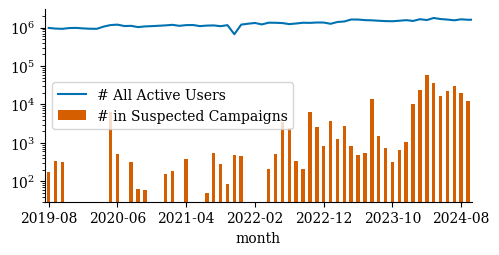

In [104]:
percentage = ts_fake_users["all"] / ts_users
print(percentage.tail())
print(ts_fake_users["all"].tail())


fig, ax = plt.subplots(1, 1, figsize=(W, H))
ts_fake_users.plot(
    y="all",
    kind="bar",
    ax=ax,
    color="C2",
)
ts_users.plot(kind="line", ax=ax, color="C0")
ax.set_yscale("log")
ax.set_xticks(range(0, len(ts_fake_users), 10))
ax.set_xticklabels(ts_fake_users.index[::10])
ax.legend(
    labels=[
        "# All Active Users",
        "# in Suspected Campaigns",
    ]
)
plot.remove_spines(ax)
fig.savefig("plots/ts_users.pdf", bbox_inches="tight")

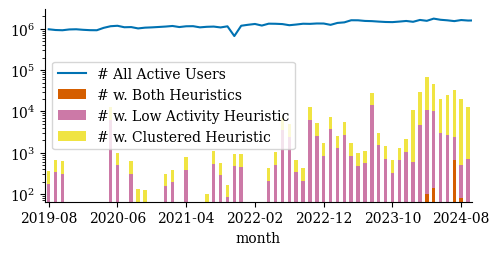

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(W, H))
ts_fake_users.plot(
    y=["both", "low_activity_actors", "all"],
    kind="bar",
    stacked=True,
    ax=ax,
    color=["C2", "C3", "C4"],
)
ts_users.plot(kind="line", ax=ax, color="C0")
ax.set_yscale("log")
ax.set_xticks(range(0, len(ts_fake_users), 10))
ax.set_xticklabels(ts_fake_users.index[::10])
ax.legend(
    labels=[
        "# All Active Users",
        "# w. Both Heuristics",
        "# w. Low Activity Heuristic",
        "# w. Clustered Heuristic",
    ]
)
plot.remove_spines(ax)
fig.savefig("plots/ts_users_detailed.pdf", bbox_inches="tight")

In [45]:
ts_fake_users

,month,low_activity,clustered,total
2019-08,2019-08,195,NaN,NaN
2019-09,2019-09,350,NaN,NaN
2019-10,2019-10,311,NaN,NaN
2019-11,2019-11,0,NaN,NaN
2019-12,2019-12,0,NaN,NaN
...,...,...,...,...
2024-05,2024-05,2991,184963.0,187954.0
2024-06,2024-06,2750,588293.0,591043.0
2024-07,2024-07,1824,578522.0,580346.0
2024-08,2024-08,423,384584.0,385007.0
